### Making Pixel Art with Deep Unsupervised Learning
In questo notebook verranno mostrati i risultati di training e degli algoritmi di post-processing sviluppati.

In ordine verranno mostrati:

1.   Risultati ottenuti dal modello sviluppato in https://inikolaeva.medium.com/make-pixel-art-in-seconds-with-machine-learning-e1b1974ba572 (Baseline)
2.   Risultati ottenuti dal mio training con Cyclegan Resnet-9 su dataset MS COCO -> Pixel art costruito da me e transfer learning.
3. Risultati ottenuti dal mio training con CycleGAN Unet-256 su dataset Cartoon -> PixelArt (https://drive.google.com/file/d/1qDXB5g0Cb0VwISXwnfeiehPHuTgxWhdG/view) e rete non pretrained.

In tutti i casi applicherò anche gli algoritmi di post-processing.

Clone della repository

In [1]:
!git clone https://github.com/felichan98/AISchools

Cloning into 'AISchools'...
remote: Enumerating objects: 19295, done.
remote: Counting objects: 100% (2511/2511), done.
remote: Compressing objects: 100% (2468/2468), done.
remote: Total 19295 (delta 45), reused 2503 (delta 40), pack-reused 16784
Receiving objects: 100% (19295/19295), 2.62 GiB | 43.49 MiB/s, done.
Resolving deltas: 100% (189/189), done.
Checking out files: 100% (2594/2594), done.


In [2]:
import sys
sys.path.insert(0,'/content/AISchools')
# Install Google Drive Download to get file from Google Drive
!pip install googledrivedownloader

Importazioni

In [3]:
import torch
from torch import nn
from torchvision import transforms
import functools
from IPython.display import Image as ipy_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from google_drive_downloader import GoogleDriveDownloader as gdd

%cd AISchools
from PaletteGen import palette_extractor
from Downsampling import pixxelate

%cd ..


import cv2

/content/AISchools
/content


#Import immagine di test

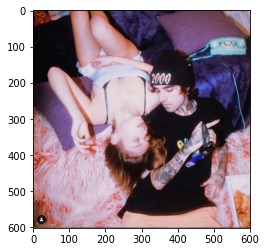

In [4]:
path = '/content/AISchools/Pictures/venz.JPG'


input_img= cv2.imread(path, cv2.IMREAD_COLOR)
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

plt.imshow(input_img)
plt.show()

#Risultato con algoritmi di palette exctraction e downsampling

True

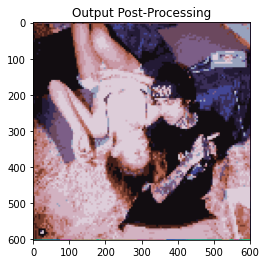

In [5]:
palette = palette_extractor(input_img)
pixel_temp = pixxelate(input_img, 128, palette)

plt.title("Output Post-Processing", fontdict=None, loc='center', pad=None)
plt.imshow(pixel_temp)
# salvo

pixel_temp = cv2.cvtColor(pixel_temp, cv2.COLOR_RGB2BGR)

cv2.imwrite('/content/AISchools/pixel_temp.png', pixel_temp)

#Util per la costruzione dei generatori.

In [6]:
def get_norm_layer(norm_type='instance'):
    """Return a normalization layer
    Parameters:
        norm_type (str) -- the name of the normalization layer: batch | instance | none
    For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    For InstanceNorm, we do not use learnable affine parameters. We do not track running statistics.
    """
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'none':
        def norm_layer(x): return Identity()
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer


def tensor2im(input_image, imtype=np.uint8):
    """"Converts a Tensor array into a numpy image array.
    Parameters:
        input_image (tensor) --  the input image tensor array
        imtype (type)        --  the desired type of the converted numpy array
    """
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor[0].cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0  # post-processing: tranpose and scaling
    else:  # if it is a numpy array, do nothing
        image_numpy = input_image
    return image_numpy.astype(imtype)


#Resnet G_A Generator

Codice del generatore Resnet presente in https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix


In [7]:
class ResnetBlock(nn.Module):
   
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Initialize the Resnet block
        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.
        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not
        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)  # add skip connections
        return out

###############################################################################


class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.
    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """
    
    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator
        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)

#Costruzione del generatore ResNet e risultati modello di Baseline

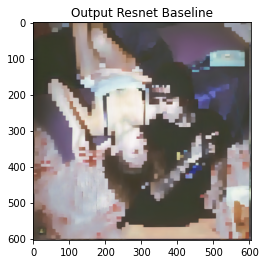

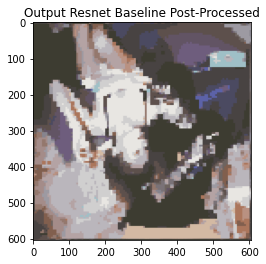

True

In [8]:
norm_layer = get_norm_layer(norm_type='instance')
net = ResnetGenerator(input_nc=3, output_nc=3, ngf=64, norm_layer=norm_layer, use_dropout=False, n_blocks=9)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
gpu_ids = [0] if torch.cuda.is_available() else []

state_dict = torch.load('/content/AISchools/Modelli/baseline_G_A.pth', map_location=device)

if len(gpu_ids) > 0:
    assert(torch.cuda.is_available())
    net.to(gpu_ids[0])
    net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs

if isinstance(net, torch.nn.DataParallel):
    net = net.module

net.load_state_dict(state_dict)

transform_A = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

A_img = transform_A(input_img)
A_img = A_img.unsqueeze(0).to(device)


fake_img_tensor1 = net(A_img)

out_nn = tensor2im(fake_img_tensor1)

save_path = '/content/AISchools/output_nn_baseline.png'

plt.title("Output Resnet Baseline", fontdict=None, loc='center', pad=None)
plt.imshow(np.array(out_nn))
plt.show()

out_nn_save_1 = cv2.cvtColor(out_nn, cv2.COLOR_RGB2BGR)

cv2.imwrite(save_path, out_nn_save_1)

##PostProcessed

save_path_2 = '/content/AISchools/output_nn_baseline_postprocessed.png'


palette = palette_extractor(out_nn)

out = pixxelate(out_nn, 128, palette)
plt.title("Output Resnet Baseline Post-Processed", fontdict=None, loc='center', pad=None)
plt.imshow(out)
plt.show()

out_nn_save_pp = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
cv2.imwrite(save_path_2, out_nn_save_pp)



#U-NET G_A Generator

Codice del generatore Unet presente in https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix


In [9]:
class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer

        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

###############################################################################

class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.

        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)


#Costruzione del generatore e output dei risultati Unet-256

Siccome il file pth di questo modello è troppo grande per essere caricato sul git, lascio qui solo i risultati. E' possibile scaricare il modello su drive *link* ed eseguire in locale attraverso lo script *prova_gen_unet.py* inserendo il file in AISchools -> Modelli

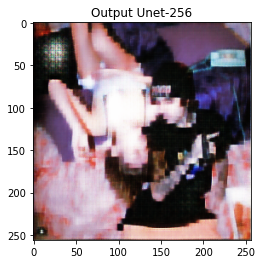

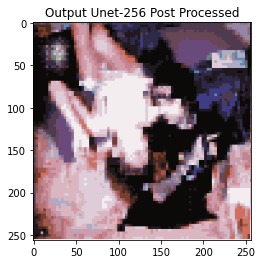

In [10]:
norm_layer = get_norm_layer(norm_type='instance')

#i parametri inseriti qui sono quelli utilizzati di default presenti in train options e nella classe baseModel
net = UnetGenerator(input_nc=3, output_nc=3, num_downs=8, ngf=64, norm_layer=norm_layer, use_dropout=False)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")    #PATCH FELICIA
gpu_ids = [0] if torch.cuda.is_available() else []

pth_path = '/content/AISchools/Modelli/unet-256-cartoon(150).pth'
#state_dict = torch.load(pth_path, map_location=device)

if len(gpu_ids) > 0:
    assert(torch.cuda.is_available())
    net.to(gpu_ids[0])
    net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs

if isinstance(net, torch.nn.DataParallel):
    net = net.module

#net.load_state_dict(state_dict)

transform_A = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#Effettuo un resize altrimenti l'input della rete non è compatibile
input_img_ = cv2.resize(input_img, (256,256), interpolation = cv2.INTER_AREA)

A_img = transform_A(input_img_)
A_img = A_img.unsqueeze(0).to(device)


fake_img_tensor1 = net(A_img)

out_nn = tensor2im(fake_img_tensor1)

#plt.imshow(out_nn)
#plt.show()


save_path1 = '/content/AISchools/output_nn_unet.png'

save_path2 = '/content/AISchools/output_nn_unet_post_processed.png'

palette = palette_extractor(out_nn)
out_final = pixxelate(out_nn, 128, palette)

out_nn_save = cv2.cvtColor(out_nn, cv2.COLOR_RGB2BGR)
out_nn_save2 = cv2.cvtColor(out_final, cv2.COLOR_RGB2BGR)

cv2.imwrite(save_path1, out_nn_save)
cv2.imwrite(save_path2, out_nn_save2)


#Show dei risultati da benchmark

path1 = '/content/AISchools/Risultati/Results-Train2/output_nn_unet.png'

path2 = '/content/AISchools/Risultati/Results-Train2/output_nn_unet_post_processed.png'


unet_output= cv2.imread(path1, cv2.IMREAD_COLOR)
unet_output = cv2.cvtColor(unet_output, cv2.COLOR_BGR2RGB)

unet_output_pp= cv2.imread(path2, cv2.IMREAD_COLOR)
unet_output_pp = cv2.cvtColor(unet_output_pp, cv2.COLOR_BGR2RGB)

plt.title("Output Unet-256", fontdict=None, loc='center', pad=None)
plt.imshow(unet_output)
plt.show()


plt.title("Output Unet-256 Post Processed", fontdict=None, loc='center', pad=None)
plt.imshow(unet_output_pp)
plt.show()


#Costruzione del generatore ResNet e risultati modello trainato su dataset Coco2Pixelart

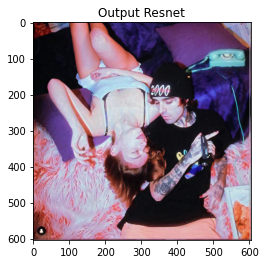

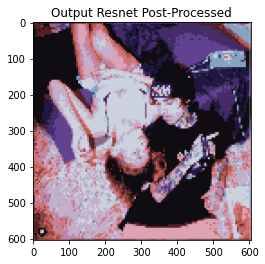

True

In [11]:
norm_layer = get_norm_layer(norm_type='instance')
net = ResnetGenerator(input_nc=3, output_nc=3, ngf=64, norm_layer=norm_layer, use_dropout=False, n_blocks=9)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
gpu_ids = [0] if torch.cuda.is_available() else []

state_dict = torch.load('/content/AISchools/Modelli/resnet-coco2pixelart.pth', map_location=device)

if len(gpu_ids) > 0:
    assert(torch.cuda.is_available())
    net.to(gpu_ids[0])
    net = torch.nn.DataParallel(net, gpu_ids)  # multi-GPUs

if isinstance(net, torch.nn.DataParallel):
    net = net.module

net.load_state_dict(state_dict)

transform_A = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

A_img = transform_A(input_img)
A_img = A_img.unsqueeze(0).to(device)


fake_img_tensor1 = net(A_img)

out_nn = tensor2im(fake_img_tensor1)

save_path = '/content/AISchools/output_nn_resnet.png'

plt.title("Output Resnet", fontdict=None, loc='center', pad=None)
plt.imshow(np.array(out_nn))
plt.show()

out_nn_save_1 = cv2.cvtColor(out_nn, cv2.COLOR_RGB2BGR)

cv2.imwrite(save_path, out_nn_save_1)

##PostProcessed

save_path_2 = '/content/AISchools/output_nn_resnet_postprocessed.png'


palette = palette_extractor(out_nn)

out = pixxelate(out_nn, 128, palette)
plt.title("Output Resnet Post-Processed", fontdict=None, loc='center', pad=None)
plt.imshow(out)
plt.show()

out_nn_save_pp = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
cv2.imwrite(save_path_2, out_nn_save_pp)

